# Berkshire Hathaway Stock Price Prediction

## Goal:
This machine learning project aims to enhance the accuracy of stock price prediction by applying and improving time series forecasting models on historical data from Berkshire Hathaway.

## Background:
Our midterm project was centered around getting the building blocks set. We used a variety of models like ARIMA, Linear Regression, and Random Forests. After some discussion and analysis that is detailed below, our final project combines a variant of ARIMA called SARIMA with Random Forest to create an ensemble for the most accurate results.

# Import Libraries and Handle Data
First, let's start off by importing the necessary libraries and loading in our dataset

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Load and parse stock data
df = pd.read_csv('./berkshire_hathaway_data.csv', index_col='Date', parse_dates=True).fillna(0)

# Plot Feature (Close Price)
We decided to focus in on the closing price because it reflects the final price of the stock at the ending of the trading day.
Unlike the high's and low's that can introduce more noise into our model, the close price is often considered the most stable which serves as a good indicator for how the stock performs overall


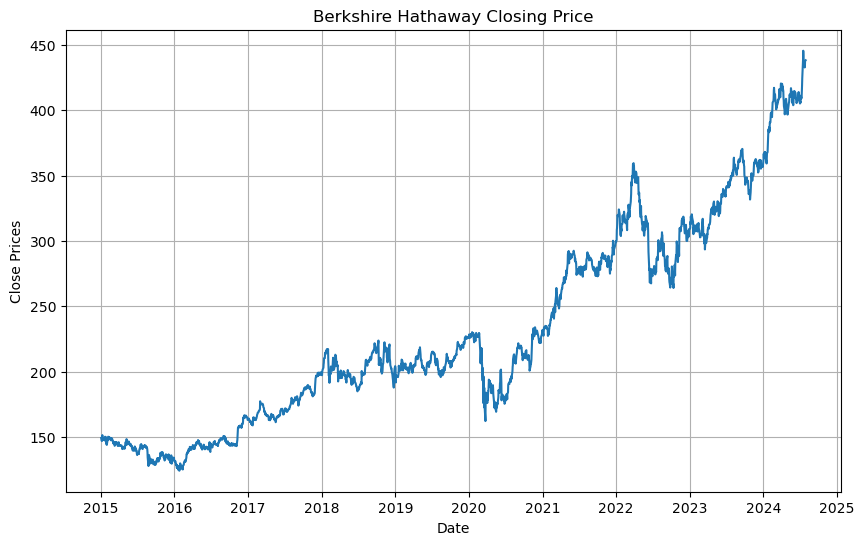

In [22]:
df_close = df['Close']

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('Berkshire Hathaway Closing Price')
plt.show()

## Data Exploration

While analyzing the graph of Berkshire Hathaway's closing prices (2015–2025), we observed the following key trends:

### 1. Long-Term Upward Trend  
The stock demonstrates a strong and consistent upward trajectory over the 10-year period. This suggests sustained investor confidence and reflects the company’s solid portfolio performance and strategic growth over time.

### 2. The 2020 Dip  
Like many companies, Berkshire Hathaway experienced a noticeable drop in early 2020, corresponding to the global COVID-19 market crash. However, the stock rebounded quickly, highlighting the company's resilience and stability amidst economic uncertainty.

### 3. Post-2021 Acceleration  
Following the 2020 recovery, the stock’s growth rate noticeably steepens after 2021. This surge indicates strong bullish sentiment and may reflect increased investor optimism, improved economic conditions, or exceptional performance of Berkshire’s holdings.

## Insights

### 1. Time Span:
The dataset spans from 2015 to 2025, offering over 2,400 daily data points

### 2. Growth Trend:
 The stock is generally growing upwards

### 3. Volatility: 
Noticeable price drops when major events in the world happen (Covid) and early 2023 witnessed the fall of Silicon Valley Bank and Signature Bank causing investors to be weary.

### 4. Stability: 
Relatively stable outside of certain uncontrollable events.

# Stationarity Testing
Most time series forecasting models like ARIMA and SARIMA require the data to be stationary to make accurate predictions. This means that the data has a constant mean, variance, and autocorrelation over time.
We perform a Dickey-Fuller Test to determine if our dataset is stationary.

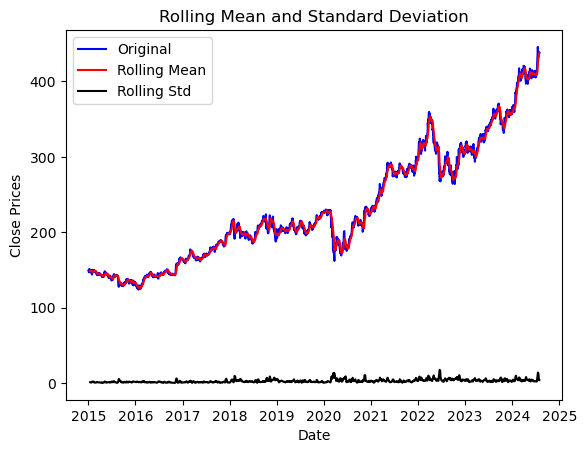

Result:
Dickey-Fuller Test Results:
Test Statistic: 0.7636122089897046
p-value: 0.9910255061533995


In [23]:
#Determing rolling statistics
rolmean = df_close.rolling(10).mean()
rolstd = df_close.rolling(10).std()

#Plot rolling statistics
plt.plot(df_close, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

# Perform the test and print results.
adft = adfuller(df_close,autolag='AIC')

print("Result:")
print("Dickey-Fuller Test Results:")
print(f"Test Statistic: {adft[0]}")
print(f"p-value: {adft[1]}")

Since the p-value > 0.05, this means the data is non-stationary. This means we will have to apply transformations like log scaling before fitting our model.
The graph also shows us that both the rolling mean and STD are not stable, supporting our test.

# Seasionality Decomposition & Log Transformations
Since our data failed our test, we will have to process our data further. We will seperate the time series into trend, seasonality, and noise. This helped us discover the need for SARIMA later on as it handles this much better. However, for visualization this is still important.

To stablize our data and remove some of the variance, we use log transformation. This helps make the data more stationary. Then we plot to determine if it remains constant over time.

C:\Users\danyi\AppData\Local\Temp\ipykernel_81064\103077772.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


<Figure size 640x480 with 0 Axes>

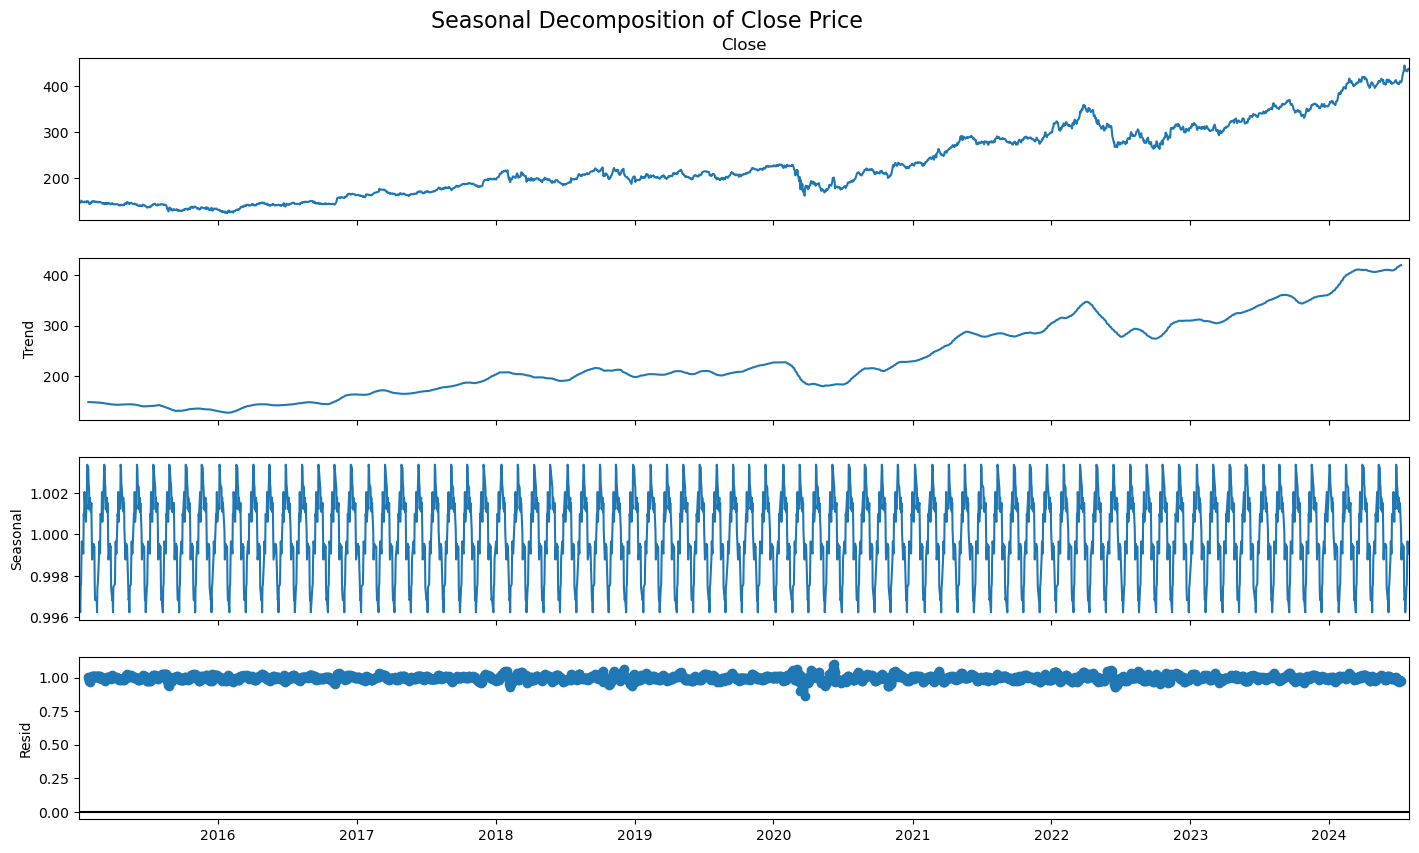

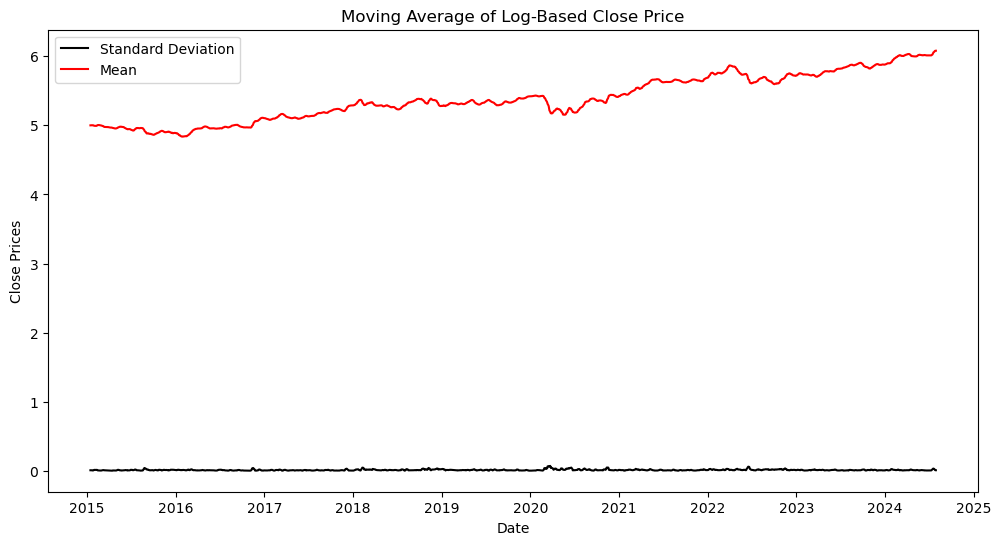

In [24]:
# Perform seasonal decomposition to seperate the time series into relevant parts (trend, seasonality, and noise)
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
fig.suptitle("Seasonal Decomposition of Close Price", fontsize=16)

# Apply log transformations
df_log = np.log(df_close)
moving_avg = df_log.rolling(10).mean()
std_dev = df_log.rolling(10).std()

# Plot Log Transformation
plt.figure(figsize=(12,6))
plt.legend(loc='best')
plt.title('Moving Average of Log-Based Close Price')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

# Split Data (Train-Test) & Auto ARIMA
Originally, wse manually calculated our ARIMA values. This left us with underwhelming results. So to improve on our previous model we prepare the dataset for auto ARIMA to get more accurate predictions and confirm the best model configuration. 

We split the data by the 80/20 rule. This gives the model enough data to train on and leaves us with a good amount to test with.

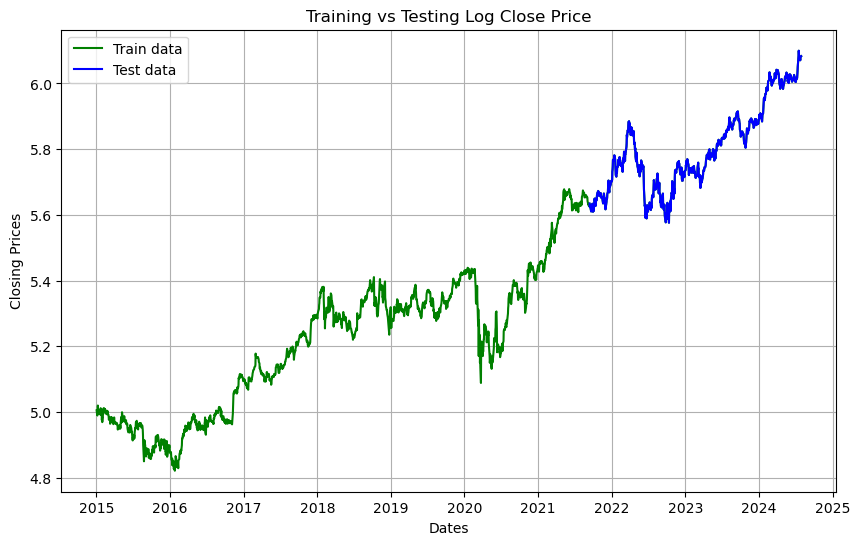

In [ ]:
# Split by the 80/20 rule
train, test = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]

# Plot the data and show the test data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.title("Training vs Testing Log Close Price")
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9889.382, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9935.168, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9929.158, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9889.989, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9938.588, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9936.787, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9936.377, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9936.514, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9934.618, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-9938.842, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9935.202, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9937.080, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-9936.568, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9936.628, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0

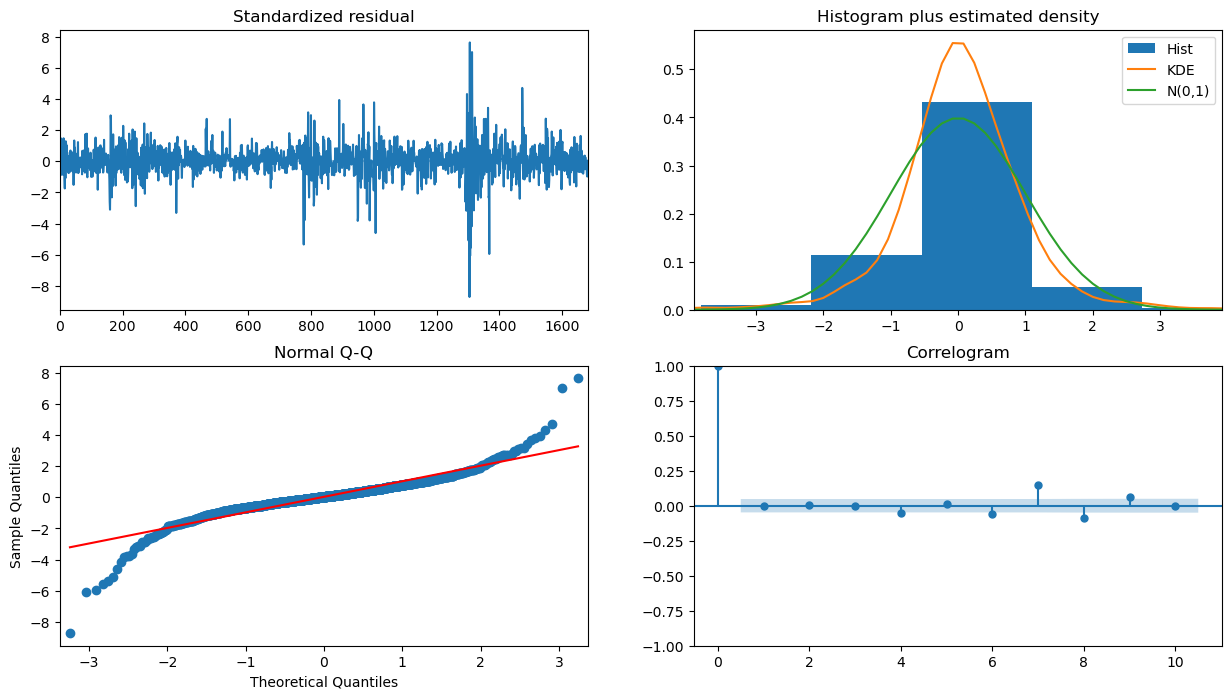

In [26]:
# Train Auto ARIMA values
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Print out result
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Train SARIMA Model & Predict
With our data explored, preprocessed, and the best configuration found we are ready to train our model. After testing both ARIMA and SARIMA, we noticed that the SARIMA performed much better. Which was one way that we improved our model.

In [27]:
# Train SARIMA model using optimal parameters from auto_arima
# To account for non-zero mean, we add a constant 'c' term
model = SARIMAX(train, order=model_autoARIMA.order, trend='c')

# Fit the model and show summary.
fitted = model.fit()
print(fitted.summary())

# Predict the length of the test values with 95% confidence intervals
forecast_result = fitted.get_forecast(len(test), alpha=0.05)

# Extract predicted mean, lower and upper bounds of the confidence interval, and standard error
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()
se = forecast_result.se_mean

c:\Users\danyi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danyi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1685
Model:               SARIMAX(2, 1, 0)   Log Likelihood                4973.294
Date:                Sun, 27 Apr 2025   AIC                          -9938.588
Time:                        22:52:18   BIC                          -9916.872
Sample:                             0   HQIC                         -9930.545
                               - 1685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.247      0.213      -0.000       0.001
ar.L1         -0.1580      0.010    -15.289      0.000      -0.178      -0.138
ar.L2          0.0567      0.011      4.979      0.0

c:\Users\danyi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danyi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\danyi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


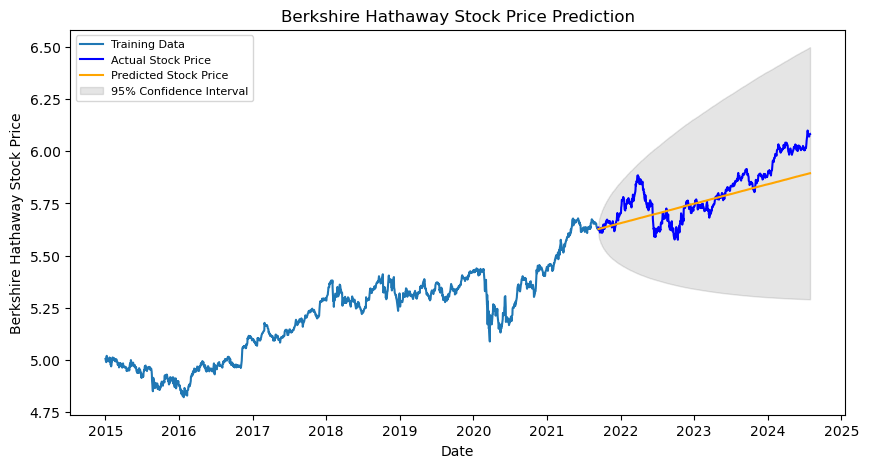

In [28]:
# Plot our predictions

plt.figure(figsize=(10,5), dpi=100)

# Plot training data
plt.plot(train.index, train.values, label='Training Data')

# Plot test data
plt.plot(test.index, test.values, color='blue', label='Actual Stock Price')

# Plot forecast values
plt.plot(test.index, fc, color='orange', label='Predicted Stock Price')

# Plot confidence intervals
plt.fill_between(test.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Berkshire Hathaway Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Berkshire Hathaway Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate Model Performance
Now for the moment of truth, we see how well our model performed using MSE, MAE, and RMSE

In [29]:
mse = mean_squared_error(test, fc)
mae = mean_absolute_error(test, fc)
rmse = math.sqrt(mean_squared_error(test, fc))
print('Evaluating: SARIMA')
print('MSE: '+ str(mse))
print('MAE: '+ str(mae))
print('RMSE: ' +str(rmse))

Evaluating: SARIMA
MSE: 0.007479658159735797
MAE: 0.06834341818465543
RMSE: 0.08648501696673128


# Train Random Forest
In addition to SARIMA, we train a Random Forest model on the same dataset. This model will help capture more complex patterns that statistical models like SARIMA might miss, potentially improving our prediction accuracy when combined in an ensemble.

In [30]:
def create_features(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create features for Random Forest
window_size = 30
X_train, y_train = create_features(train.values, window_size)
X_test = []
for i in range(len(train) - window_size, len(train) - window_size + len(test)):
    if i + window_size <= len(df_log):
        X_test.append(df_log.values[i:i+window_size])
X_test = np.array(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest
rf_predictions = rf_model.predict(X_test)

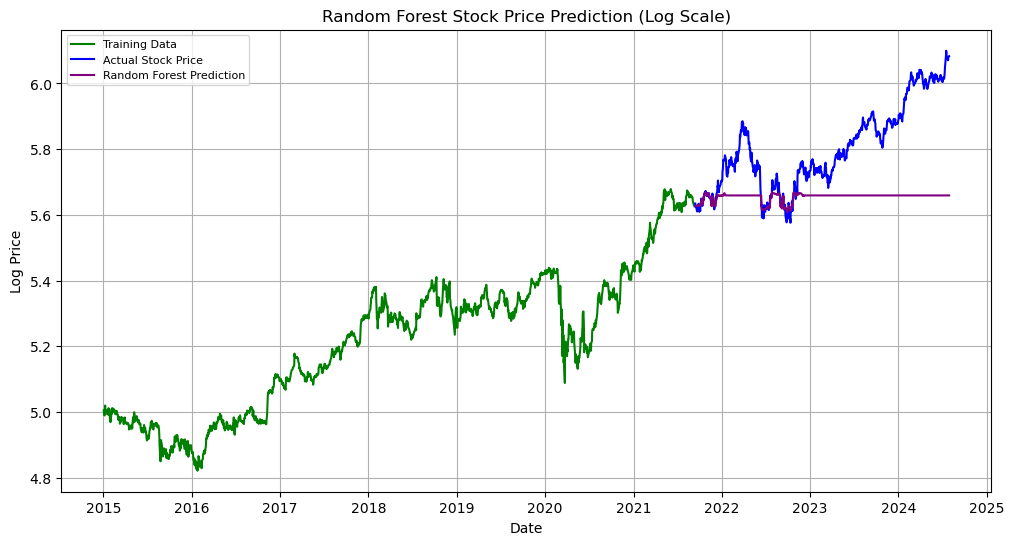

In [31]:
# Plot Random Forest Model
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='green')
plt.plot(test.index, test, label='Actual Stock Price', color='blue')
plt.plot(test.index[:len(rf_predictions)], rf_predictions[:len(test.index)], label='Random Forest Prediction', color='purple')

plt.title('Random Forest Stock Price Prediction (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

# Evaluate Random Forest

In [32]:
rf_mse = mean_squared_error(test[:len(rf_predictions)], rf_predictions)
rf_mae = mean_absolute_error(test[:len(rf_predictions)], rf_predictions)
rf_rmse = math.sqrt(rf_mse)

print("Results: Random Forest")
print('MSE: ' + str(rf_mse))
print('MAE: ' + str(rf_mae))
print('RMSE: ' + str(rf_rmse))

Results: Random Forest
MSE: 0.03616680642850245
MAE: 0.14681867565425055
RMSE: 0.19017572512942457


# Results
As seen in the graph, the random forest model captures the up and down nature of the stock price much more closely compared to SARIMA, but struggles towards the end. Our goal is to combine both of these models.

# Ensemble Time!
Now it's time to combine our two models to create a more accurate one. The idea was to capture the strengths of both models. SARIMA captures linear and seasonal trends, while Random Forest captures non-linear patterns.

In [33]:
# Use weights to tune the model
window = 10 
rf_recent_mse = mean_squared_error(test[-window:].values[:len(rf_predictions[-window:])], rf_predictions[-window:])
sarima_recent_mse = mean_squared_error(test[-window:].values[:len(fc[-window:])], fc[-window:].values)    

# Inverse weighting by error (lower error = higher weight)
total_error = rf_recent_mse + sarima_recent_mse
rf_weight = sarima_recent_mse / total_error if total_error > 0 else 0.8
sarima_weight = rf_recent_mse / total_error if total_error > 0 else 0.2

ensemble_predictions = (sarima_weight * fc.values) + (rf_weight * rf_predictions)

# Evaluate Performance
ensemble_mse = mean_squared_error(test[:len(ensemble_predictions)], ensemble_predictions)
ensemble_mae = mean_absolute_error(test[:len(ensemble_predictions)], ensemble_predictions)
ensemble_rmse = math.sqrt(ensemble_mse)

print("Results: Ensemble")
print('MSE: ' + str(ensemble_mse))
print('MAE: ' + str(ensemble_mae))
print('RMSE: ' + str(ensemble_rmse))

Results: Ensemble
MSE: 0.009912412089590527
MAE: 0.07811333934265878
RMSE: 0.09956109726992028


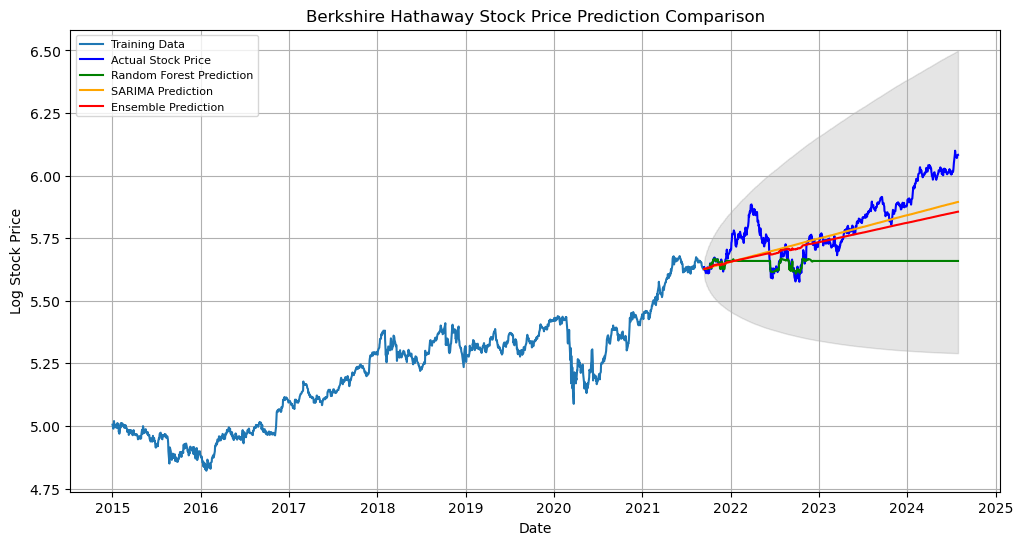

In [34]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Training Data')
plt.plot(test.index, test.values, color='blue', label='Actual Stock Price')
plt.plot(test.index[:len(rf_predictions)], rf_predictions, color='green', label='Random Forest Prediction')
plt.plot(test.index, fc, color='orange', label='SARIMA Prediction')
plt.plot(test.index[:len(ensemble_predictions)], ensemble_predictions, color='red', label='Ensemble Prediction')
plt.fill_between(test.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.1)
plt.title('Berkshire Hathaway Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

# Bar Graph Comparing Models

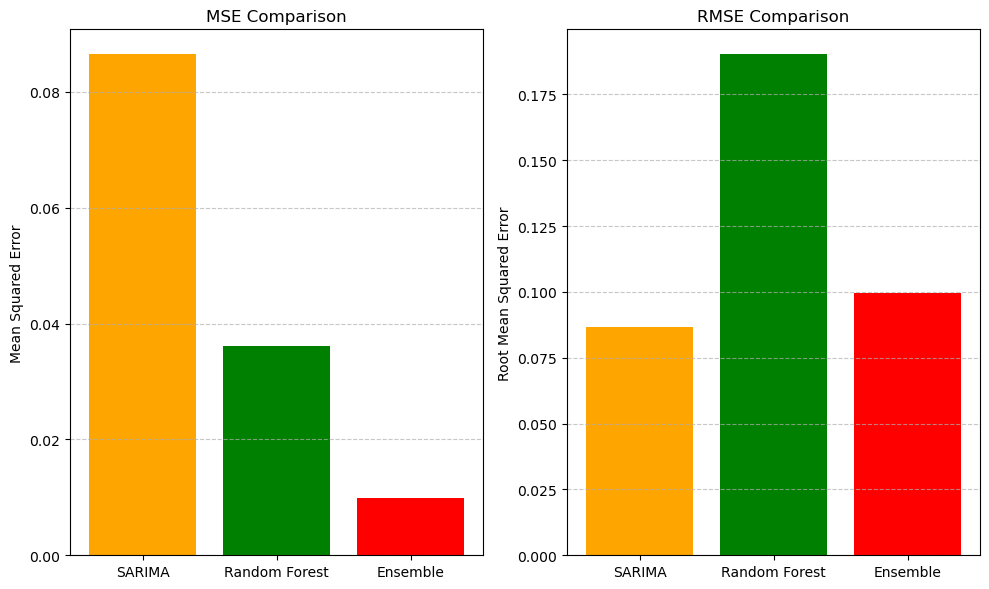

In [35]:
# Create a bar chart to compare MSE values
models = ['SARIMA', 'Random Forest', 'Ensemble']
mse_values = [rmse, rf_mse, ensemble_mse]
rmse_values = [rmse, rf_rmse, ensemble_rmse]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=['orange', 'green', 'red'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color=['orange', 'green', 'red'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()